In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


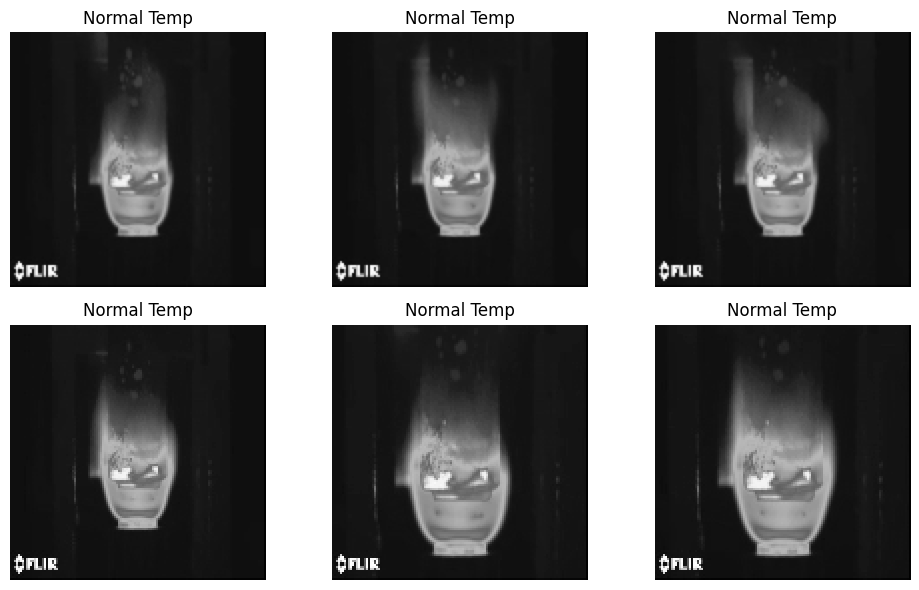

In [3]:
# Path to dataset
dataset_path = r"D:\DIP project\datset\IR_flame_dataset\IR_dataset"

# Function to load images
def load_images(data_dir):
    images = []
    labels = []
    for set_type in ["train_set", "test_set", "vali_set"]:
        set_path = os.path.join(data_dir, set_type)
        for group in os.listdir(set_path):
            group_path = os.path.join(set_path, group)
            for img_file in os.listdir(group_path):
                img_path = os.path.join(group_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                img = cv2.resize(img, (128, 128))  # Resize for consistency
                images.append(img)
                labels.append(1 if "high_temp" in group.lower() else 0)  # Example labeling
    return np.array(images), np.array(labels)

# Load dataset
images, labels = load_images(dataset_path)

# Display a few samples
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title("High Temp" if labels[i] == 1 else "Normal Temp")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
print(images.shape)


(2640, 128, 128)


In [5]:
# Normalize images
images = images / 255.0
images = images.reshape(-1, 128, 128, 1)

# Split into training, validation, and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


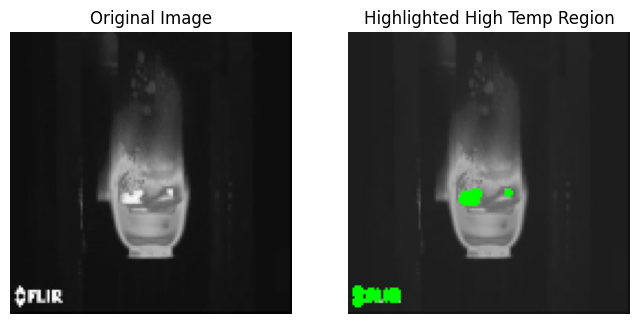

In [6]:
# Function to highlight the brightest region
def highlight_high_temp_region(image):
    # Threshold the image to extract the brightest region
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # Draw contours on the image
    cv2.drawContours(output, contours, -1, (0, 255, 0), 2)
    return output

# Apply to a sample image
sample_image = images[0].reshape(128, 128) * 255  # Reshape for visualization
highlighted = highlight_high_temp_region(sample_image.astype('uint8'))

# Display original and highlighted image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(highlighted)
plt.title("Highlighted High Temp Region")
plt.axis('off')
plt.show()


In [7]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
datagen.fit(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_val, y_val), 
                    epochs=3, verbose=1)


Epoch 1/3
58/58 [==============================] - 41s 684ms/step - loss: 0.0125 - accuracy: 0.9859 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
58/58 [==============================] - 26s 444ms/step - loss: 3.0320e-27 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
58/58 [==============================] - 28s 474ms/step - loss: 1.5068e-21 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


13/13 - 1s - loss: 0.0000e+00 - accuracy: 1.0000 - 1s/epoch - 83ms/step
Test Accuracy: 1.00


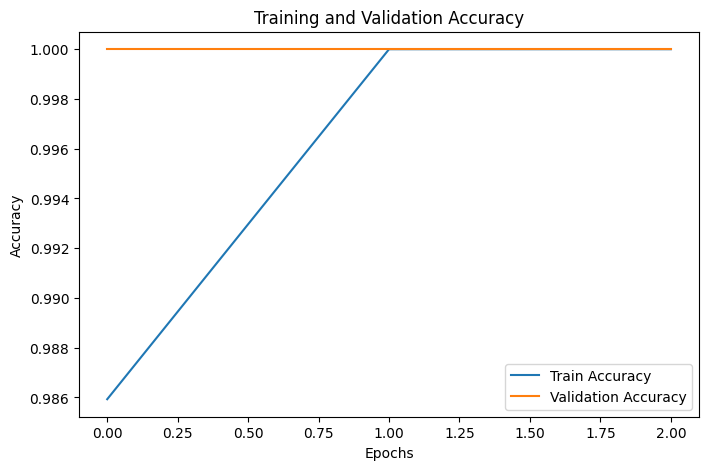

In [8]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Predict on test images
predictions = (model.predict(X_test) > 0.5).astype('int')

# Visualize predictions
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title("Predicted: High Temp" if predictions[i] == 1 else "Predicted: Normal Temp")
    plt.axis('off')
plt.tight_layout()
plt.show()
